For an up-to-date version / full view of the plotly - plots, please, go to

Interest rate model: https://drive.google.com/file/d/19t7v80wOd2_AaWW540qVnbiX6OhUd-UR/view?usp=sharing


# LendingClub Prediction: Interest Rate



In this step I will predict the interest rate of LendingClub's loan data.




## Imports

In [1]:
%%capture
! pip install scikit-learn==1.2.2 # use old version like for classifiers
! pip install xgboost==2.0.2

! pip install -q fastparquet==2024.2.0
! pip install -q dask==2023.8.1
! pip install -q pandas==1.5.3
! pip install -q numpy==1.25.2

#! pip install -q eli5
#! pip install -q shap
#! pip install -q sklego

In [2]:
import numpy as np
import pandas as pd

import sys
import os
import warnings

from dask import dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                   LabelEncoder)

#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import RFECV #, RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import (RepeatedKFold,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold)
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR, LinearSVR
#from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV #, #RidgeregressorCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#from sklearn.metrics import accuracy_score, f1_score

from scipy.stats import randint, loguniform, uniform

import copy

#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.experimental import enable_halving_search_cv # noqa
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

#import eli5
#from eli5.sklearn import PermutationImportance
#import shap
#from sklearn.feature_extraction.text import TfidfVectorizer
#
#from yellowbrick.classifier import (ROCAUC,
#                                    PrecisionRecallCurve,
#                                    DiscriminationThreshold)
#
#from sklego.meta import Thresholder


import pickle


# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=False)


from google.colab import drive
drive.mount("/content/gdrive")

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#pd.reset_option('display.max_rows')

Mounted at /content/gdrive


In [3]:
home_folder = '/content/gdrive/MyDrive/Colab Notebooks/Portfolio/ML_LendingClub/'

### Functions

The Python-file with the functions is at
https://drive.google.com/file/d/1JWLo8HAhUdu5xkDG4-tu7MiUSLgSxOjQ/view?usp=sharing


In [46]:
%load_ext autoreload
%autoreload 2

sys.path.append(home_folder)
import lendfunc as lfunc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
! pip freeze > /content/gdrive/MyDrive/Colab\ Notebooks/Portfolio/ML_LendingClub/requirements.txt

# Model - Interest Rate

### Data Preparation

In [6]:
parquet_home_acc_cleaned = home_folder+'parquet_LCacc_cleaned/'
#parquet_home_rej_cleaned = home_folder+'parquet_LCrej_cleaned/'

In [7]:
LCacc_dd = dd.read_parquet(parquet_home_acc_cleaned, ignore_metadata_file=True)
#LCrej_dd = dd.read_parquet(parquet_home_rej_cleaned, ignore_metadata_file=True)

#### Data Selection by Loan Status (Charged Off vs Fully Paid)

In [8]:
simple = 'loan_status_simple'

LCacc_dd[simple] = LCacc_dd[simple].astype('object')
LCacc_PC_dd = LCacc_dd.loc[(LCacc_dd.loan_status_simple == 'Fully Paid') |
                           (LCacc_dd.loan_status_simple == 'Charged Off')]
LCacc_dd[simple] = LCacc_dd[simple].astype('category')

#### Reduce Categories

Modification based on EDA (categories too small to be considered for modelling ---> reduce OHE-features by removing strong-minority categories):
* remove ANY, OTHER, NONE (each < 0.02%) *from* home ownership
* eduactional, renewable_energy, wedding (each < 0.5%) from purpose

In [9]:
LCacc_dd['home_ownership'] = LCacc_dd['home_ownership'].astype('object')
LCacc_dd['purpose'] = LCacc_dd['purpose'].astype('object')

LCacc_PC_dd = LCacc_PC_dd.loc[~(LCacc_PC_dd.home_ownership.isin(['ANY',
                                                                 'OTHER',
                                                                 'NONE']))]
LCacc_PC_dd = LCacc_PC_dd.loc[~(LCacc_PC_dd.purpose.isin(['educational',
                                                          'renewable_energy',
                                                          'wedding']))]

LCacc_dd['home_ownership'] = LCacc_dd['home_ownership'].astype('category')
LCacc_dd['purpose'] = LCacc_dd['purpose'].astype('category')

#### Create Sample for Modelling

Take most recent data:

In [10]:
LCacc_PC_dd_2015 = LCacc_PC_dd.loc[LCacc_PC_dd.issue_d_year == 2015]

In [11]:
size_PC_2015 = len(LCacc_PC_dd_2015)

In [12]:
size_PC_2015

374924

In [13]:
size_PC = len(LCacc_PC_dd)

In [14]:
accSAMPLES = 10000
frac_PC = accSAMPLES/size_PC_2015

LCacc_PC_dd_model=LCacc_PC_dd.sample(frac=frac_PC, replace=False, random_state=19)

In [15]:
LCacc_PC_model = LCacc_PC_dd_model.compute()
len(LCacc_PC_model)

35157

In [16]:
LCacc_PC_model.to_csv(home_folder+'M3-S3-LendingClub_model_PC.csv', index=False)

### Cross Validations and Score Metric Definitions

In [17]:
cvRK = RepeatedKFold(n_splits=5, n_repeats= 10, random_state=1)
cvSK = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
cvSKs = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cvRSK = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

In [18]:
scoring = 'neg_mean_absolute_error'
#scoring = 'r2'


### Base Estimators

If computation time allows I am curious about the performances of as many regressors as possible. Therefore I hold a collection of them ready to use.

DEFINE HERE THE SET OF REGRESSORS TO BE USED in this run:

In [19]:
regressors=[#'Linear SVR',    # too slow
            #'Radial SVR',    # too slow
            'Linear Regression',
            'Ridge Regression',
            #'KNN',
            ###'Decision Tree',   # needs debugging for model_scores!
            #'Random Forest',  # too slow
            'LightGBM',
            #'XGBoost'
            ]

Base regressor Setup

In [20]:
%reload_ext autoreload

LinSVR = SVR(kernel='linear')
rbfSVR = SVR(kernel='rbf')


#RandomizedSearch takes too long with probability=True
#--> create extra version for hypertuning
LinSVR_hypersearch = SVR(kernel='linear')
rbfSVR_hypersearch = SVR(kernel='rbf')

LinReg = LinearRegression(n_jobs=-1)
RidgeReg = Ridge()

KNNReg = KNeighborsRegressor(n_jobs=-1)
DTReg = DecisionTreeRegressor(random_state = 1),
RFReg = RandomForestRegressor(random_state = 1, n_jobs=-1)
LGBMReg = lfunc.LGBMRegressorWithEarlyStop(random_state=1,
                                           early_stopping_round=10,
                                           verbosity=-100,
                                           force_row_wise=True,
                                           #force_col_wise=True,
                                           )
XGBReg = lfunc.XGBoostRegressorWithEarlyStop(random_state=1,
                                             enable_categorical=False,
                                             eval_metric=['merror','mlogloss'],
                                             verbosity=0)

# estimators and their names
regressor_map = {'Linear SVR': LinSVR,
                  'Radial SVR': rbfSVR,
                  'Linear Regression': LinReg,
                  'Ridge Regression': RidgeReg,
                  'KNN': KNNReg,
                  'Decision Tree': DTReg,
                  'Random Forest': RFReg,
                  'LightGBM': LGBMReg,
                  'XGBoost': XGBReg
}

### Test Train Split

EDA-based selection of features:

In [21]:
# EDA results
best_num_feat = ['inq_last_12m',
                 'dti',
                 'loan_amnt',
                 'delinq_2yrs',
                 'pub_rec_bankruptcies',
                 'fico_range_high',
                 'annual_inc',
                 'mo_sin_old_il_acct',
                 ]

best_cat_feat = ['term',
                  'emp_length',
                  'home_ownership',
                  'verification_status',
                  'purpose'
                  ]

target_cols = ['grade', 'sub_grade', 'loan_status_simple', 'int_rate']


Collect additional features form the recursive feature elimination (RFE) results from first run including all numerical features. I plan to gather these by a PCA in the preprocessor.

In [22]:
# Use RFE results from first run including all numerical features

RFE_features = ['num__loan_amnt',
 'num__tot_hi_cred_lim',
 'num__pub_rec_bankruptcies',
 'num__pct_tl_nvr_dlq',
 'num__num_tl_op_past_12m',
 'num__num_sats',
 'num__num_rev_tl_bal_gt_0',
 'num__total_bal_ex_mort',
 'num__num_op_rev_tl',
 'num__num_bc_tl',
 'num__num_bc_sats',
 'num__num_actv_rev_tl',
 'num__num_actv_bc_tl',
 'num__mths_since_recent_inq',
 'num__mort_acc',
 'num__num_il_tl',
 'num__total_bc_limit',
 'num__total_il_high_credit_limit',
 'num__issue_d_year',
 'cat__purpose_vacation',
 'cat__purpose_small_business',
 'cat__purpose_other',
 'cat__purpose_moving',
 'cat__purpose_medical',
 'cat__purpose_major_purchase',
 'cat__purpose_house',
 'cat__purpose_home_improvement',
 'cat__purpose_debt_consolidation',
 'cat__purpose_credit_card',
 'cat__purpose_car',
 'cat__home_ownership_RENT',
 'cat__home_ownership_OWN',
 'cat__home_ownership_MORTGAGE',
 'num__earliest_cr_line_year',
 'num__mo_sin_rcnt_tl',
 'num__mo_sin_old_rev_tl_op',
 'num__mths_since_recent_bc',
 'ord__term',
 'num__tot_cur_bal',
 'num__mths_since_rcnt_il',
 'num__tot_coll_amt',
 'num__acc_now_delinq',
 'num__il_util',
 'num__total_acc',
 'num__revol_util',
 'num__pub_rec',
 'num__open_rv_12m',
 'num__open_rv_24m',
 'num__open_acc',
 'num__inq_last_6mths',
 'num__open_acc_6m',
 'num__all_util',
 'num__inq_fi',
 'num__total_cu_tl',
 'num__inq_last_12m',
 'num__fico_range_high',
 'num__delinq_2yrs',
 'num__acc_open_past_24mths',
 'num__dti',
 'num__avg_cur_bal',
 'num__bc_open_to_buy',
 'num__annual_inc',
 'num__int_rate',
 'num__total_rev_hi_lim',
 'num__open_il_12m']



#RFE_features = ['num__acc_open_past_24mths',
# 'num__all_util',
# 'num__annual_inc',
# 'num__bc_open_to_buy',
# 'num__dti',
# 'num__earliest_cr_line_year',
# 'num__fico_range_high',
# 'num__il_util',
# 'num__inq_fi',
# 'num__inq_last_12m',
# 'num__inq_last_6mths',
# 'num__issue_d_year',
# 'num__loan_amnt',
# 'num__mths_since_rcnt_il',
# 'num__mths_since_recent_inq',
# 'num__num_tl_op_past_12m',
# 'num__open_acc_6m',
# 'num__open_il_12m',
# 'num__open_rv_12m',
# 'num__open_rv_24m',
# 'num__revol_util',
# 'num__tot_hi_cred_lim',
# 'num__total_bc_limit',
# 'num__total_cu_tl',
# 'num__total_rev_hi_lim']
#
RFE_num = []
for item in RFE_features:
    if item.split('__')[0]=='num':
        RFE_num.append(item.replace('num__',''))

for item in best_num_feat+target_cols:
    if item in RFE_num:
        RFE_num.remove(item)

RFE_num

['tot_hi_cred_lim',
 'pct_tl_nvr_dlq',
 'num_tl_op_past_12m',
 'num_sats',
 'num_rev_tl_bal_gt_0',
 'total_bal_ex_mort',
 'num_op_rev_tl',
 'num_bc_tl',
 'num_bc_sats',
 'num_actv_rev_tl',
 'num_actv_bc_tl',
 'mths_since_recent_inq',
 'mort_acc',
 'num_il_tl',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'issue_d_year',
 'earliest_cr_line_year',
 'mo_sin_rcnt_tl',
 'mo_sin_old_rev_tl_op',
 'mths_since_recent_bc',
 'tot_cur_bal',
 'mths_since_rcnt_il',
 'tot_coll_amt',
 'acc_now_delinq',
 'il_util',
 'total_acc',
 'revol_util',
 'pub_rec',
 'open_rv_12m',
 'open_rv_24m',
 'open_acc',
 'inq_last_6mths',
 'open_acc_6m',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'total_rev_hi_lim',
 'open_il_12m']

In [23]:
#num_feat_rest = LCacc_PC_model.select_dtypes(include=np.number).columns.tolist()
#for item in best_num_feat+target_cols:
#    if item in num_feat_rest:
#        num_feat_rest.remove(item)

Construct the model data set and encode the labels

In [24]:
#num_feat_orig = LCacc_PC_model.select_dtypes(include=np.number).columns.tolist()
#features = num_feat_orig + best_cat_feat

features = RFE_num + best_num_feat + best_cat_feat
#features = num_feat_rest + best_num_feat + best_cat_feat
#features = best_num_feat + best_cat_feat

X = LCacc_PC_model[features]
y = LCacc_PC_model['int_rate'].to_frame()

In [25]:
#LE = LabelEncoder()
#y = LE.fit_transform(y)

#labels = LE.classes_.tolist()
#labels

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)
                                                    #stratify = y) # <---- no stratify for cont. var!!!!!

X_train_analysis = X_train.copy()
X_test_analysis = X_test.copy()


### Preprocessor Setup

**Setup of the Ordinal Encoder**

Ranking information for Verification Status:

Verified income means that Lending Club independently verified both the source and size of reported income, source verified means that they verified only the source of the income, and not verified means there was no independent verification of the reported values.

https://michaeltoth.me/analyzing-historical-default-rates-of-lending-club-notes.html

In [27]:
ordinal_encode = {'emp_length': ['< 1 year', '1 year', '2 years', '3 years',
                                 '4 years', '5 years', '6 years', '7 years',
                                 '8 years', '9 years', '10+ years'],
                  'verification_status': ['Not Verified', 'Source Verified', 'Verified'],
                  'term': [' 36 months', ' 60 months']
}

ord_stepname_pre = "ord_"

ordinal_impute_step = ("imputer", SimpleImputer(strategy="most_frequent"))
ordinal_transformers=[]

for key in ordinal_encode.keys():
    ordinal_step = ('ordenc', OrdinalEncoder(handle_unknown="error",
                    categories = [ordinal_encode[key]]))
    ordinal_transformer = Pipeline(steps = [ordinal_impute_step,
                                            ordinal_step])
    ordinal_transformer_key = (ord_stepname_pre + key, ordinal_transformer, [key])
    ordinal_transformers.append(ordinal_transformer_key)

In [28]:
#### switch this here on and off for the use of ordinal encoding:
#ordinal_encode={}

**Setup of the Numerical and Categorical Transformers**

In [29]:
from sklearn.decomposition import PCA

numeric_transformer_pca = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler()),
           ('pca', PCA(n_components=5))
           ]
)

In [30]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())
           ]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(handle_unknown="ignore")),
           ]
)

**Define the ColumnTransformer preprocessing Pipeline and gather the new Columns Names**

In [31]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feat = X_train.select_dtypes(exclude=np.number).columns.tolist()
ord_feat = ordinal_encode.keys()

# if ordinal, remove ordinal features from categorical feature list
if ordinal_encode:
    for feat in ord_feat:
        if feat in cat_feat:
            cat_feat.remove(feat)

# basic transformer
transformers=[("num", numeric_transformer, best_num_feat),
              ("num_pca", numeric_transformer_pca, RFE_num),
              ("cat", categorical_transformer, cat_feat)
              ]

# if ordinal, extend basic transformer
if ordinal_encode:
    transformers.extend(ordinal_transformers)


# THE PREPROCESSOR
preprocessor = ColumnTransformer(transformers=transformers,
                                 remainder='passthrough'
                                 )


# restoring the columns names after transform:
X_train_transformed = preprocessor.fit_transform(X_train)

new_cols = preprocessor.get_feature_names_out().tolist()

# rename ordinal
for key in ordinal_encode.keys():
   list_index = new_cols.index(ord_stepname_pre+key+"__"+key)
   new_cols[list_index] = ord_stepname_pre+"_"+key

# test if restoring worked (fails for inconsistent shape/length)
X_train_prep = pd.DataFrame(X_train_transformed, columns=new_cols)

#X_train_prep.columns

Turn preprocessor, etc., into general pipeline steps to which the next steps can be appended, e.g. over/undersampling, regressor.


In [32]:
X_transformer_steps = [('preprocessor', preprocessor)]

# general pipeline preprocessing steps, i.e. append over/undersampling
pipe_prep_steps = X_transformer_steps.copy()



In [33]:
print('The number of features increased from', len(X_train.columns), 'to',
      len(X_train_prep.columns), 'after preprocessing.' )
#len(X_train.columns), len(X_train_prep.columns)

The number of features increased from 55 to 30 after preprocessing.


In [34]:
# how to access infos:
# preprocessor.transformers[0][2]

### Feature Selection

This section is used for assessing/verify the importance of the selected features.

One of the following algorithms could also be used inside a pipeline as automatic feature selector.
Among them, I rely on RFE most since it considers the relations of the features among each other, while the first two methods are univeriate. The downside of the RFE is its computation time depending on the number of features and test algorithm.
Therefore, I decided against incorporation into the pipeline and just hard wire the final feature setup in the 'Test Train Split Section'.


#### SelectKBest

In [35]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('f_classif', SelectKBest(score_func=f_classif, k=20)))

KBest_pipe = Pipeline(pipe_steps)

KBest_pipe.fit(X_train,y_train)


KBest = KBest_pipe.named_steps['f_classif'].get_feature_names_out()

KBest_cols = []
for feature in KBest:
    index_nr = int(feature.replace('x', ''))
    KBest_cols.append(new_cols[index_nr])

KBest_cols

['num__inq_last_12m',
 'num__dti',
 'num__loan_amnt',
 'num__fico_range_high',
 'num__annual_inc',
 'num_pca__pca1',
 'num_pca__pca2',
 'num_pca__pca3',
 'num_pca__pca4',
 'cat__home_ownership_RENT',
 'cat__purpose_car',
 'cat__purpose_credit_card',
 'cat__purpose_house',
 'cat__purpose_major_purchase',
 'cat__purpose_medical',
 'cat__purpose_moving',
 'cat__purpose_other',
 'cat__purpose_small_business',
 'ord__verification_status',
 'ord__term']

#### RidgeCV

Another try-out: a regularization algorithm that returns features importances:

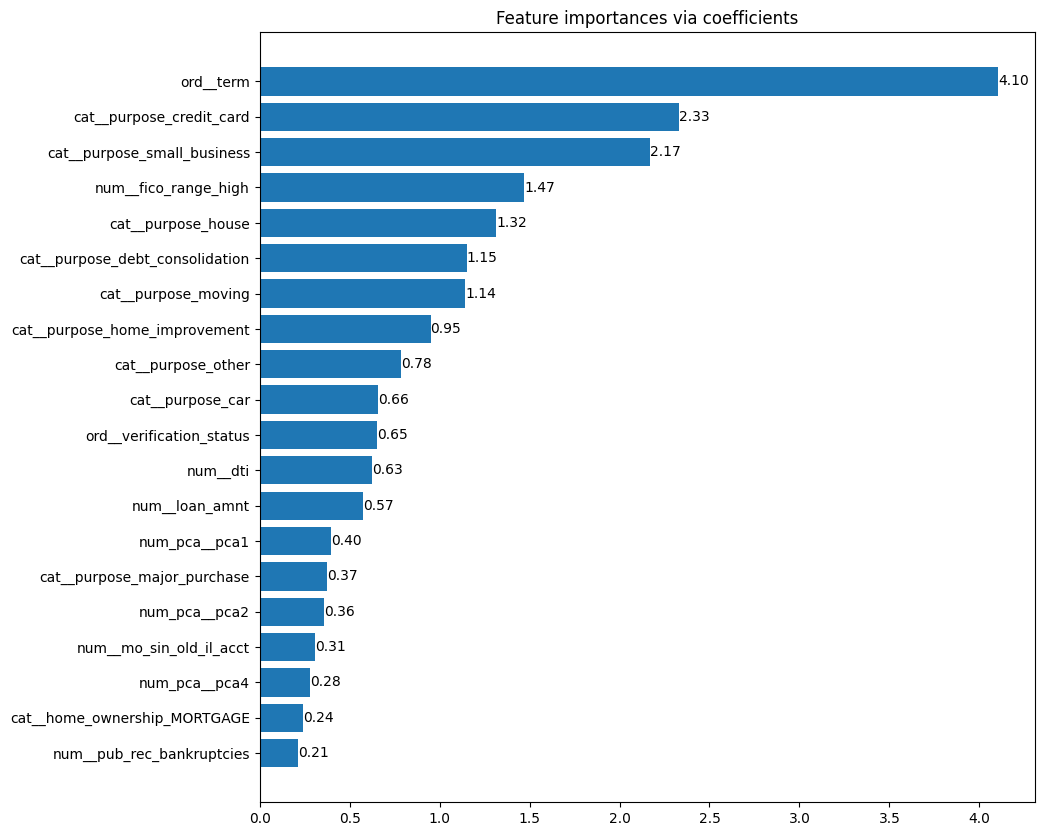

In [36]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5),
                          scoring = scoring, cv = cvRK)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('Feature Selection', ridge))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(ridge.coef_[0])

ridge_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
ridge_df.reset_index(inplace=True)
ridge_df = ridge_df.sort_values(by='Importance',ascending=False)



fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

hbars = ax.barh(ridge_df['index'][:20], ridge_df['Importance'][:20], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()



In [37]:
KBest_cols.sort()
KBest_cols

['cat__home_ownership_RENT',
 'cat__purpose_car',
 'cat__purpose_credit_card',
 'cat__purpose_house',
 'cat__purpose_major_purchase',
 'cat__purpose_medical',
 'cat__purpose_moving',
 'cat__purpose_other',
 'cat__purpose_small_business',
 'num__annual_inc',
 'num__dti',
 'num__fico_range_high',
 'num__inq_last_12m',
 'num__loan_amnt',
 'num_pca__pca1',
 'num_pca__pca2',
 'num_pca__pca3',
 'num_pca__pca4',
 'ord__term',
 'ord__verification_status']

#### Recursive Feature Elimination (RFECV)

Attempt to reduce the number of features through recursive feature elimination:

In [38]:
%%time
# the error:  "when importance_getter=='auto', the underlying estimator X
# should have 'coef_' or 'feature_importances_' attribute."
# limits the pool of estimator that are easy to use:

#model=RidgeReg
model = LinReg
##model = LogReg
#model = RFReg
#model = LinSVR
#model = DTReg #Clas


rfecv = RFECV(estimator=model,
              #cv=cvRSK,  ### takes ages!!! >13min
              cv=cvRK, # for classification
              #cv=cvRK, # for regression
              scoring = scoring
              )


pipeline = Pipeline([('preprocessor', preprocessor),
                     ('Feature Selection', rfecv)
                     ])

pipeline.fit(X_train,y_train)

rfecv_df = pd.DataFrame(rfecv.ranking_,index=new_cols,columns=['Rank'])
rfecv_df.reset_index(inplace=True)
rfecv_df = rfecv_df.sort_values(by='Rank',ascending=True)
rfecv_df

CPU times: user 1min 28s, sys: 28.4 s, total: 1min 56s
Wall time: 1min 13s


,index,Rank
0,num__inq_last_12m,1
26,cat__purpose_vacation,1
25,cat__purpose_small_business,1
24,cat__purpose_other,1
23,cat__purpose_moving,1
22,cat__purpose_medical,1
21,cat__purpose_major_purchase,1
20,cat__purpose_house,1
19,cat__purpose_home_improvement,1
18,cat__purpose_debt_consolidation,1


In [39]:
mean_score = np.max(rfecv.cv_results_["mean_test_score"]).round(5)
print('The mean', scoring, 'scoring is:', mean_score)

The mean neg_mean_absolute_error scoring is: -2.65023


The first try-out were based on the R2-metric - meanwhile I switched to MAE which is less sensitive to outliers.

R2 CV score for best_num_feat + best_cat_feat: 0.424.

R2 CV score for best_num_feat + best_cat_feat+PCA(all other: 0.462.

R2 CV score for best_num_feat + best_cat_feat(OHE and ordinal)+PCA(5, all other best RFE*): 0.471.




(*) first rfecv with all numerical fetures included ---> best n features ~ 60
take these, subtract best_num_feat and best_cat_feat and put into PCA

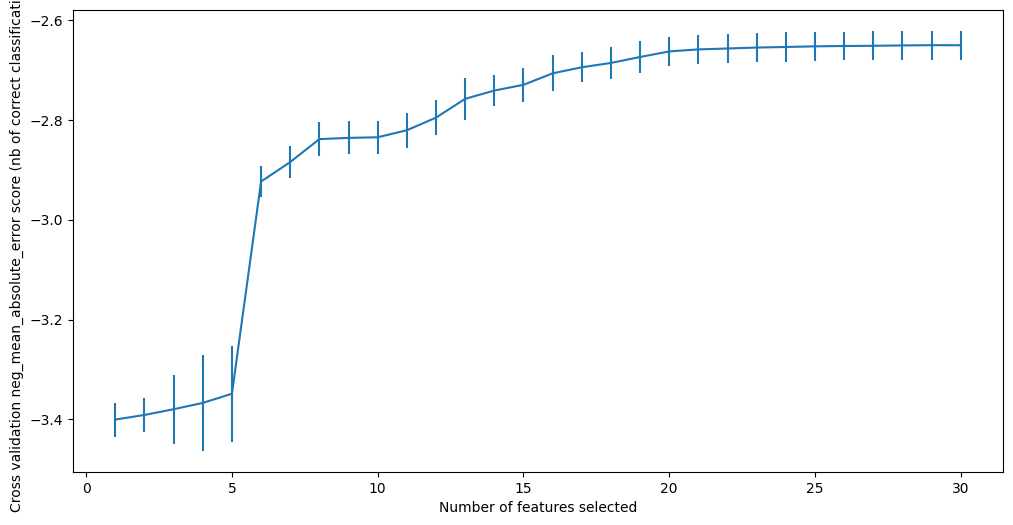

In [40]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation ' +scoring+ ' score (nb of correct classifications)')
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

In [41]:
#rfecv.cv_results_["mean_test_score"].round(3)

### Scores per Basic Model BEFORE Hyperparameter Tuning

First, we do a crossvalidation on support vector machines, logistic regression, k-nearest neighbors, decision tree, and random forest, LightGBM, and XGBoost algorithms with their default parameters to see where we stand.

In [42]:
#regressors=[#'Linear SVR',
#            #'Radial SVR',
#            #'Linear Regression',
#            #'Ridge Regression',
#            #'KNN',
#            #'Decision Tree',
#            #'Random Forest',
#            #'LightGBM',
#            'XGBoost'
#]

In [47]:
%%time
%reload_ext autoreload

estimators_basic = []
for clas in regressors:
    estimators_basic.append(regressor_map[clas])

models_basic=[]
for estimator in estimators_basic:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('regressor' , estimator))
    models_basic.append(Pipeline(steps=pipe_steps))

model_cv_results_before = lfunc.model_scores(X_train,y_train,X_test,
                                      models = models_basic,
                                      model_type = 'regression',
                                      model_names = regressors,
                                      cv = cvRK)

(model_performance_before,
 collect_cv_results_before,
 model_predict_before,
 model_fitted_estimators) = model_cv_results_before

Executing Linear Regression
Executing Ridge Regression
Executing LightGBM
Done!
CPU times: user 2min 8s, sys: 33.2 s, total: 2min 41s
Wall time: 1min 57s


In [48]:
model_performance_before.round(3)

,r2 mean,r2 std,explained variance mean,explained variance std,neg median absolute error mean,neg median absolute error std,neg mean absolute error mean,neg mean absolute error std,neg mean squared error mean,neg mean squared error std,neg root mean squared error mean,neg root mean squared error std
Linear Regression,0.468,0.009,0.468,0.009,2.166,0.034,2.650,0.029,11.815,0.265,3.437,0.039
Ridge Regression,0.468,0.009,0.468,0.009,2.166,0.034,2.651,0.029,11.816,0.265,3.437,0.039
LightGBM,0.521,0.007,0.521,0.007,1.977,0.029,2.481,0.027,10.647,0.223,3.263,0.034


Reminder:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

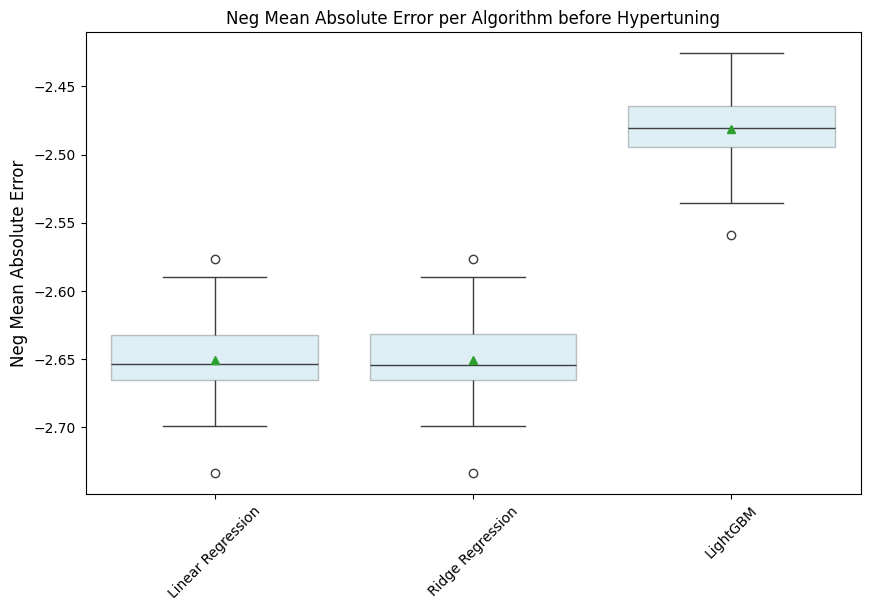

In [49]:
score_metric = scoring
lfunc.plot_model_score([collect_cv_results_before],
                 score = score_metric, classifiers_names = regressors,
                 colors = ['skyblue'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before Hypertuning')  ;

## Hyperparameter Tuning with RandomizedSearchCV

Continue with the old selection of estimator or can we rule out some of them? ---> new list.

In [50]:
regressors_h = regressors

In a previous project, I have made the function 'hyper_search' to loop over the given estimators and several (grid-)search-varieties ('Grid', 'HalvingGrid', 'Random', 'HalvingRandom').
In the following, I will focus on RandomizedSearchCV, which performed best in the previous projects.

The dummy estimator in the pipeline will be replaced by the regressors in the hyperparameter dictionaries

In [51]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('regressor' , RandomForestRegressor()))

pipe = Pipeline(pipe_steps, memory=memory)   # cache pipeline results except from last step

In the following, I create the parameter distribution for Randomized SearchCV per regressor. Since XGBoost and LightGBM are fast, I let them test more parameters.

In [52]:
%reload_ext autoreload

# Create param distribution (Randomized Search) per regressor

hyper_distro_XGBR = {
          'regressor' : [XGBReg],
          "regressor__n_estimators": randint(50, 1000),
          "regressor__max_depth": randint(1, 10),
          "regressor__scale_pos_weight": uniform(1, 30),
          "regressor__learning_rate": uniform(0.05, 0.2),
          'regressor__early_stopping_rounds': randint(5, 10),
          "regressor__min_child_weight": randint(1, 12),       # min. number of obs. (hessians) in a node to make split
          "regressor__gamma": uniform(0, 1),                   # L0 regularization - dep. on number of leaves
          "regressor__reg_alpha": uniform(0, 1),               # L1 regularization
          "regressor__reg_lambda": uniform(loc=0, scale=1),    # L2 regularization
          "regressor__subsample": uniform(0.1, 1),
          "regressor__colsample_bytree": uniform(0.1, 1),

      }


hyper_distro_LightGBMR = {
        'regressor' : [LGBMReg],
        "regressor__n_estimators": randint(50, 1000),
        "regressor__max_depth": randint(1, 12),
        "regressor__boosting_type": ["gbdt"],
        "regressor__learning_rate": uniform(0.05, 0.2),
        "regressor__reg_alpha": loguniform(1e-8, 100.0),
        "regressor__reg_lambda": loguniform(1e-8, 100.0),
        "regressor__num_leaves": randint(2, 256),
        'regressor__early_stopping_round': randint(1, 10),
        #"regressor__feature_fraction": uniform(0.4, 1.0),
        #"regressor__bagging_fraction": uniform(0.4, 1.0),
        #"regressor__bagging_freq": randint(1, 7),
        "regressor__min_child_samples": randint(5, 100),

        }

hyper_distro_LinSVR = {'regressor' : [LinSVR_hypersearch],
     'regressor__C' : loguniform(0.01, 1e3)}

hyper_distro_rbfSVR = {'regressor' : [rbfSVR_hypersearch],
     'regressor__kernel' : ['rbf'],
     'regressor__C' : loguniform(0.01, 1e3),
     'regressor__gamma': loguniform(0.01, 1e3)}

#hyper_distro_LogReg = {'regressor' : [LogReg],
#     'regressor__C' : loguniform(0.01, 1e3)}

hyper_distro_KNNR = {'regressor' : [KNNReg],
             'regressor__n_neighbors' : randint(1, 21),
             'regressor__weights' : ['uniform','distance'],
             'regressor__metric' : ['minkowski','euclidean','manhattan']}

#https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
hyper_distro_DTR = {'regressor' : [DTReg],
     'regressor__min_samples_split' : randint(2, 41),
     'regressor__min_samples_leaf' : randint(1, 21)}

hyper_distro_RFR = {'regressor' : [RFReg],
     'regressor__n_estimators' : randint(10, 1000),
     #'regressor__max_features': ['sqrt', 'log2', None],
     #'regressor__max_depth': randint(1, 10),
     #'regressor__max_leaf_nodes': randint(1, 10)
                    }




hyper_distro_LinR = {'regressor' : [LinReg],
                    }

hyper_distro_Ridge = {'regressor' : [RidgeReg],
     'regressor__alpha' : loguniform(0.01, 1e2),
                    }



# regressors and their corresponding hyperparameter setup
param_distro_map = {'Linear SVR': hyper_distro_LinSVR,
                  'Radial SVR': hyper_distro_rbfSVR,
                  'Linear Regression': hyper_distro_LinR,
                  'Ridge Regression': hyper_distro_Ridge,
                  #'Logistic Regression': hyper_distro_LogReg,
                  'KNN': hyper_distro_KNNR,
                  'Decision Tree': hyper_distro_DTR,
                  'Random Forest': hyper_distro_RFR,
                  'LightGBM': hyper_distro_LightGBMR,
                  'XGBoost': hyper_distro_XGBR
}

# hyperparameter setups used in this run:
param_distro = []
for clas in regressors_h:
    param_distro.append(param_distro_map[clas])

**Derive the Hyperparameters**

In [53]:
%%time
%reload_ext autoreload

start = 0
stop = 4

hyper_params = lfunc.hyper_search(pipe,  X_train, y_train,
                            param_distributions = param_distro,
                            classifier_names = regressors,
                            cv = cvRK, niter = 20,
                            searches = ['Random'],
                            scoring = scoring,
                            verbose=0)

Executing Linear Regression
for search method: Random
best score: -2.65
best parameters: {'regressor': LinearRegression(n_jobs=-1)}
 
Executing Ridge Regression
for search method: Random
best score: -2.65
best parameters: {'regressor': Ridge(), 'regressor__alpha': 16.86544201250597}
 
Executing LightGBM
for search method: Random
best score: -2.466
best parameters: {'regressor': LGBMRegressorWithEarlyStop(boosting_type='gbdt', class_weight=None,
                           colsample_bytree=1.0, early_stopping_round=10,
                           force_row_wise=True, importance_type='split',
                           learning_rate=0.1, max_depth=-1,
                           min_child_samples=20, min_child_weight=0.001,
                           min_split_gain=0.0, n_estimators=100, n_jobs=None,
                           num_leaves=31, objective=None, random_state=1,
                           reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                           subsample_for_bin=2

In [54]:
hyper_params

,classifier,search method,best score,time[s],best params
0,Linear Regression,Random,-2.650,29.3,{'regressor': LinearRegression(n_jobs=-1)}
1,Ridge Regression,Random,-2.650,93.9,"{'regressor': Ridge(), 'regressor__alpha': 16.86544201250597}"
2,LightGBM,Random,-2.466,559.8,"{'regressor': LGBMRegressorWithEarlyStop(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, early_stopping_round=10, force_row_wise=True, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=None, num_leaves=31, objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0, subsample_for_bin=200000, subsample_freq=0, verbosity=-100), 'regressor__boosting_type': 'gbdt', 'regressor__early_stopping_round': 9, 'regressor__learning_rate': 0.13392825388781515, 'regressor__max_depth': 4, 'regressor__min_child_samples': 79, 'regressor__n_estimators': 323, 'regressor__num_leaves': 195, 'regressor__reg_alpha': 16.688414670411188, 'regressor__reg_lambda': 1.012824216419752}"


Extract the best tuned hyperparameters per regressor:

In [55]:
param_regressors={}


for regressor in regressors:
    param_regressor = hyper_params.loc[(hyper_params['classifier']==regressor)]
    param_regressor = param_regressor.loc[param_regressor['best score']==param_regressor['best score'].max()]['best params'].values[0]
    # replace the 'regressor__' in the keys --> can insert best params directly into untuned regressors
    if 'regressor' in param_regressor.keys():
        param_regressor.pop('regressor')
    new_keys = [key.replace('regressor__','') for key in param_regressor.keys()]
    param_regressor = dict(zip(new_keys, list(param_regressor.values())))
    print(param_regressor)
    param_regressors[regressor] = param_regressor

{}
{'alpha': 16.86544201250597}
{'boosting_type': 'gbdt', 'early_stopping_round': 9, 'learning_rate': 0.13392825388781515, 'max_depth': 4, 'min_child_samples': 79, 'n_estimators': 323, 'num_leaves': 195, 'reg_alpha': 16.688414670411188, 'reg_lambda': 1.012824216419752}


##### Update the base regressors with the hypertuned parameters:

In [56]:
%%capture

LinSVR_h = copy.deepcopy(LinSVR_hypersearch)
if 'Linear SVR' in param_regressors.keys():
    LinSVR_h.set_params(**param_regressors['Linear SVR'])

rbfSVR_h = copy.deepcopy(rbfSVR_hypersearch)
if 'Radial SVR' in param_regressors.keys():
    rbfSVR_h.set_params(**param_regressors['Radial SVR'])


LinReg_h = copy.deepcopy(LinReg)
if 'Linear Regression' in param_regressors.keys():
    LinReg_h.set_params(**param_regressors['Linear Regression'])

RidgeReg_h = copy.deepcopy(RidgeReg)
if 'Ridge Regression' in param_regressors.keys():
    RidgeReg_h.set_params(**param_regressors['Ridge Regression'])

KNNReg_h = copy.deepcopy(KNNReg)
if 'KNN' in param_regressors.keys():
    KNNReg_h.set_params(**param_regressors['KNN'])

DTReg_h = copy.deepcopy(DTReg)
if 'Decision Tree' in param_regressors.keys():
    DTReg_h.set_params(**param_regressors['Decision Tree'])

RFReg_h = copy.deepcopy(RFReg)
if 'Random Forest' in param_regressors.keys():
    RFReg_h.set_params(**param_regressors['Random Forest'])

LGBMReg_h = copy.deepcopy(LGBMReg)
if 'LightGBM' in param_regressors.keys():
    LGBMReg_h.set_params(**param_regressors['LightGBM'])

XGBReg_h = copy.deepcopy(XGBReg)
if 'XGBoost' in param_regressors.keys():
    XGBoost_param_fit={}
    # cross_val_score cannot deal with 'early_stopping_rounds'
    # ---> put it into fit_params for the fit-function:
    if 'early_stopping_rounds' in param_regressors['XGBoost']:
        XGBoost_param_fit['regressor__early_stopping_rounds'] = param_regressors['XGBoost']['early_stopping_rounds']
        param_regressors['XGBoost'].pop('early_stopping_rounds')
    XGBReg_h.set_params(**param_regressors['XGBoost'])



# hypertuned estimators and their names

regressor_map_h = {'Linear SVR': LinSVR_h,
                  'Radial SVR': rbfSVR_h,
                  'Linear Regression': LinReg_h,
                  'Ridge Regression': RidgeReg_h,
                  'KNN': KNNReg_h,
                  'Decision Tree': DTReg_h,
                  'Random Forest': RFReg_h,
                  'LightGBM': LGBMReg_h,
                  'XGBoost': XGBReg_h
}

## Scores per Basic Model AFTER Hyperparameter Tuning

Let's redo the crossvalidation on the algorithms with their now tuned parameters.

In [57]:
%%time
%reload_ext autoreload

estimators_hyped = []
for clas in regressors_h:
    estimators_hyped.append(regressor_map_h[clas])

models_hyped=[]
fit_params_hyped=[]
for estimator in estimators_hyped:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('regressor' , estimator))
    models_hyped.append(Pipeline(pipe_steps))

    if estimator == XGBReg_h:
        fit_params_hyped.append(XGBoost_param_fit)
    else:
        fit_params_hyped.append(None)

model_cv_results_after = lfunc.model_scores(X_train,y_train,X_test,
                                      models = models_hyped,
                                      model_type = 'regression',
                                      model_names = regressors_h,
                                      fit_params = fit_params_hyped,
                                      cv = cvRK)

(model_performance_after,
 collect_cv_results_after,
 model_predicts_after,
 model_fitted_estimators_h) = model_cv_results_after

Executing Linear Regression
Executing Ridge Regression
Executing LightGBM
Done!
CPU times: user 2min 14s, sys: 32.9 s, total: 2min 47s
Wall time: 2min 6s


In [58]:
model_performance_after.round(3)

,r2 mean,r2 std,explained variance mean,explained variance std,neg median absolute error mean,neg median absolute error std,neg mean absolute error mean,neg mean absolute error std,neg mean squared error mean,neg mean squared error std,neg root mean squared error mean,neg root mean squared error std
Linear Regression,0.468,0.009,0.468,0.009,2.166,0.034,2.650,0.029,11.815,0.266,3.437,0.039
Ridge Regression,0.468,0.009,0.468,0.009,2.166,0.034,2.650,0.029,11.815,0.265,3.437,0.039
LightGBM,0.526,0.007,0.526,0.007,1.970,0.032,2.467,0.024,10.527,0.204,3.244,0.031


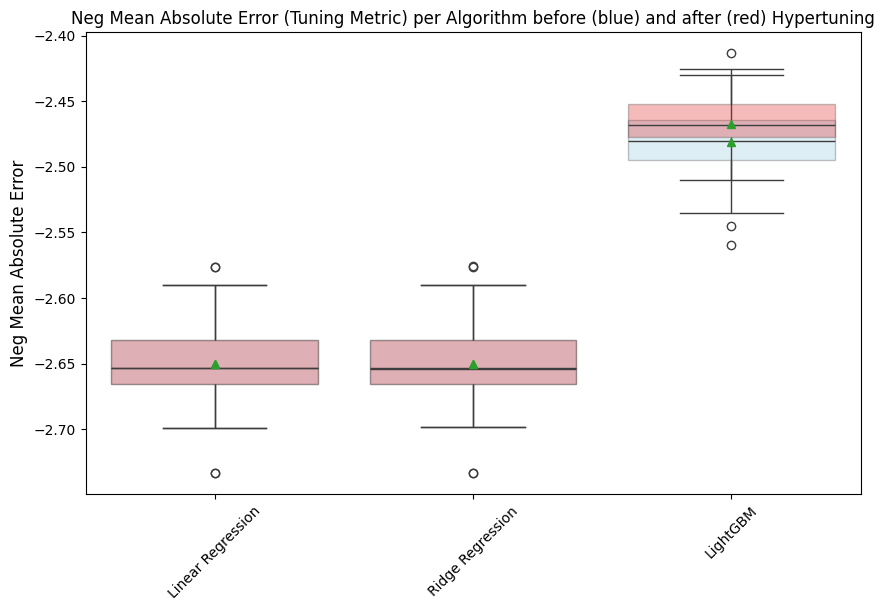

In [59]:
%reload_ext autoreload

score_metric = scoring
lfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = regressors_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' (Tuning Metric) per Algorithm before (blue) '+
                        'and after (red) Hypertuning')  ;

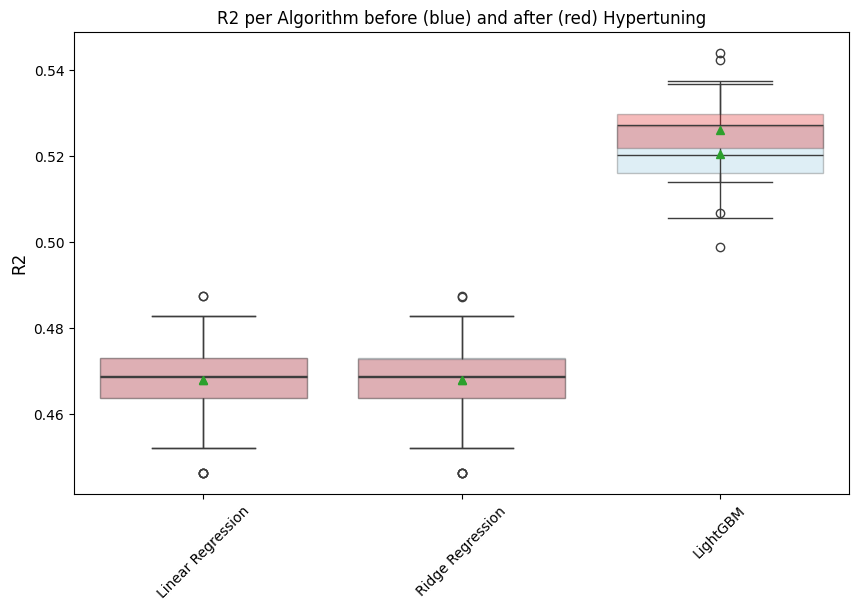

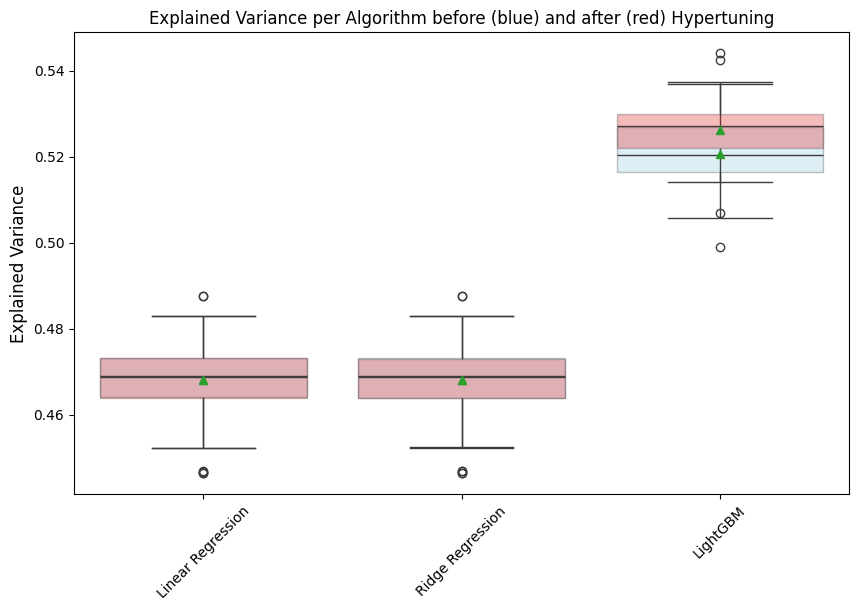

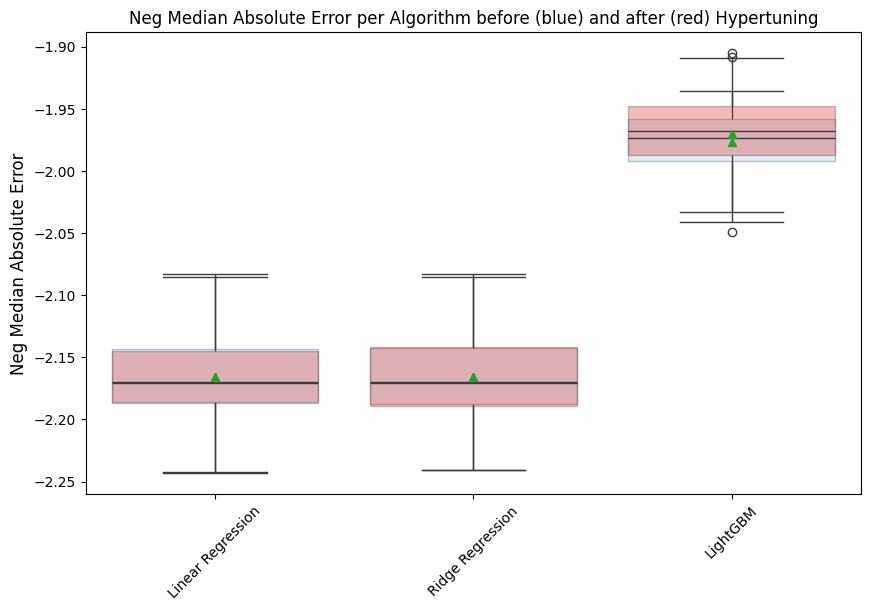

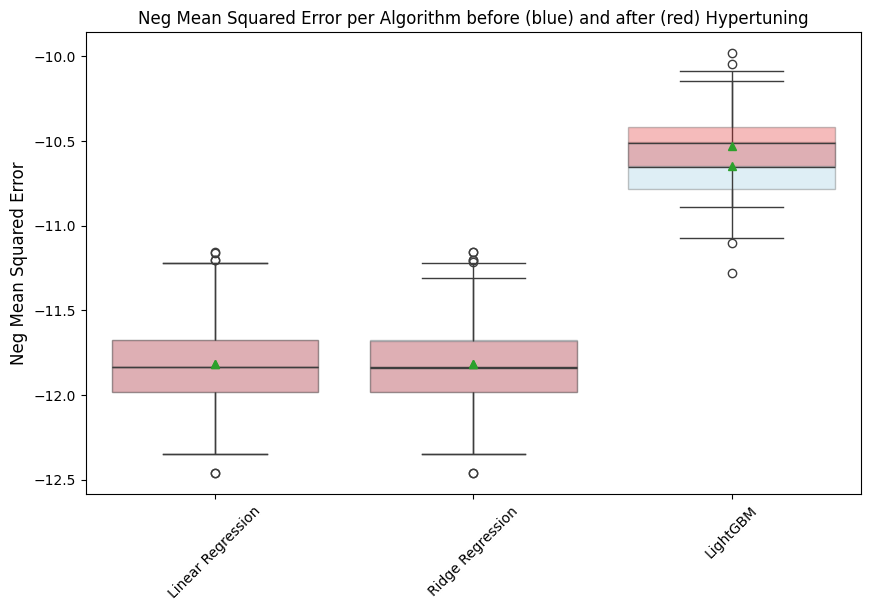

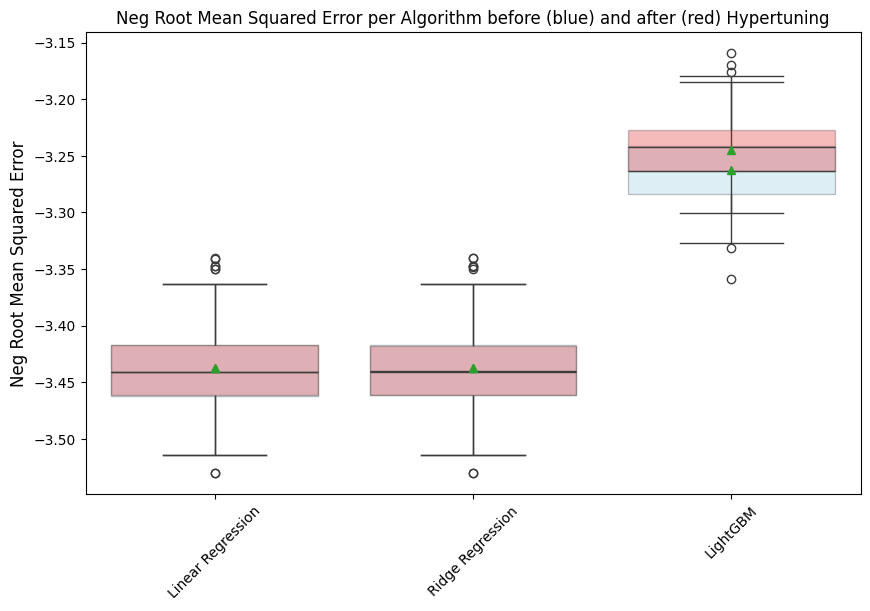

In [60]:
%reload_ext autoreload

score_metrics = ['r2', 'explained_variance', 'neg_median_absolute_error',
                   'neg_mean_absolute_error', 'neg_mean_squared_error',
                   'neg_root_mean_squared_error']

for score_metric in score_metrics:
    if score_metric is not scoring:
        lfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = regressors_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before (blue) '+
                        'and after (red) Hypertuning')  ;

#### Residual Plots after Hypertune




Diagnostic Plots for Model: Linear Regression

Red dashed line: mean residual: 0.04



Diagnostic Plots for Model: Ridge Regression

Red dashed line: mean residual: 0.04



Diagnostic Plots for Model: LightGBM

Red dashed line: mean residual: 0.03


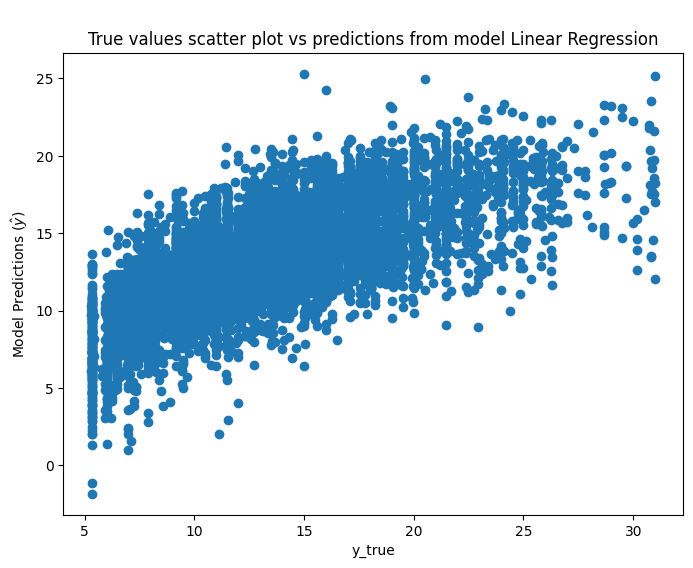

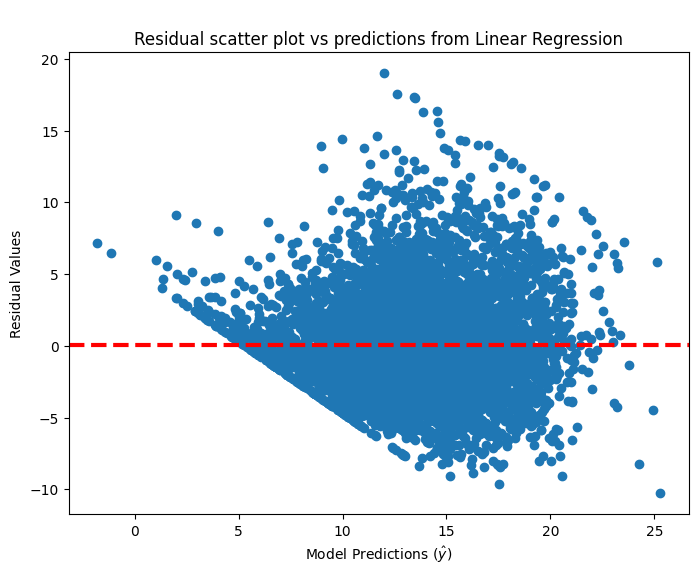

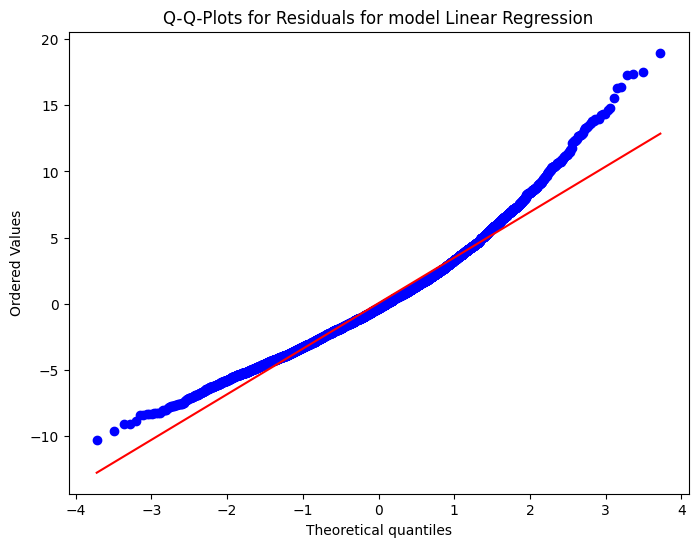

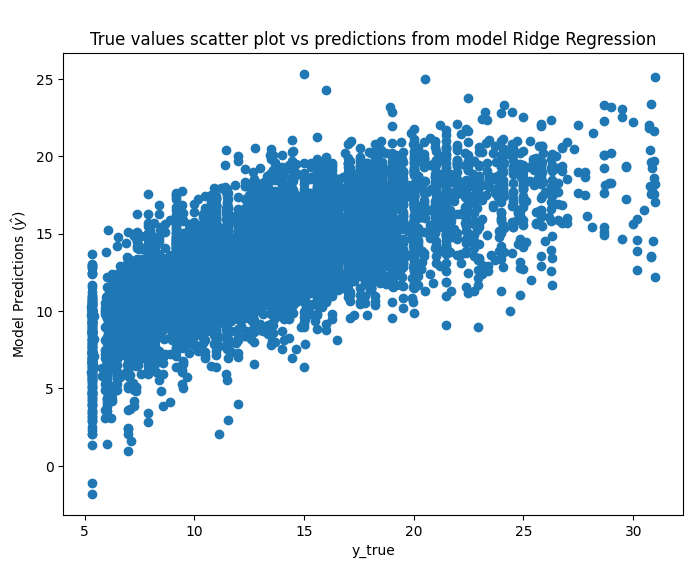

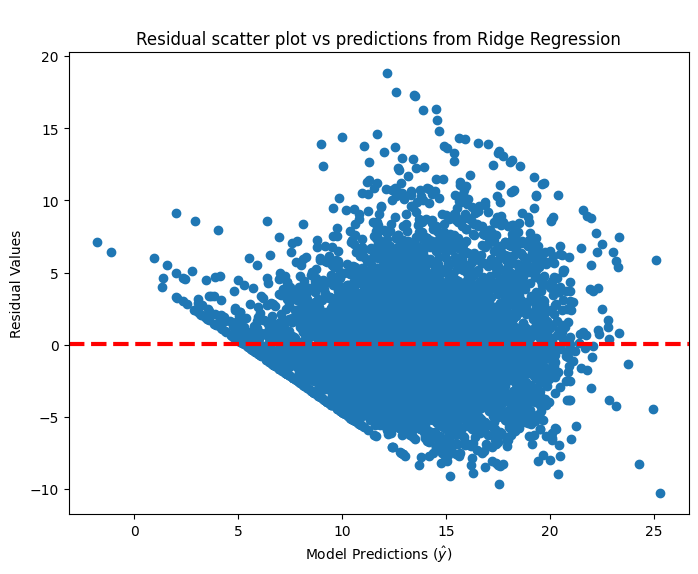

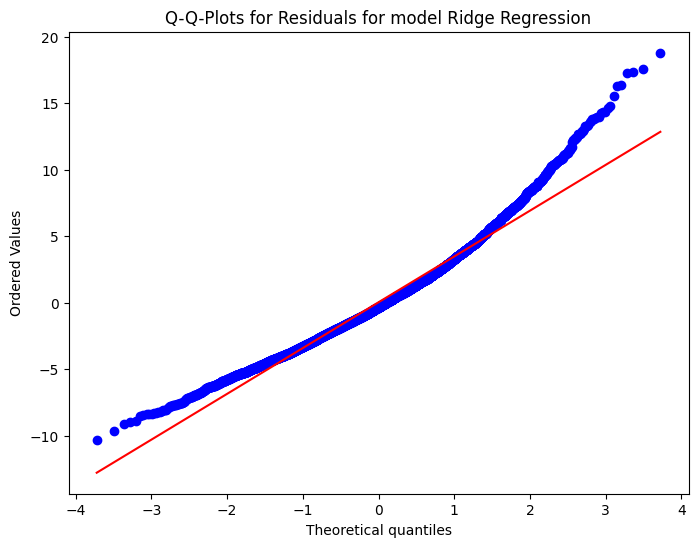

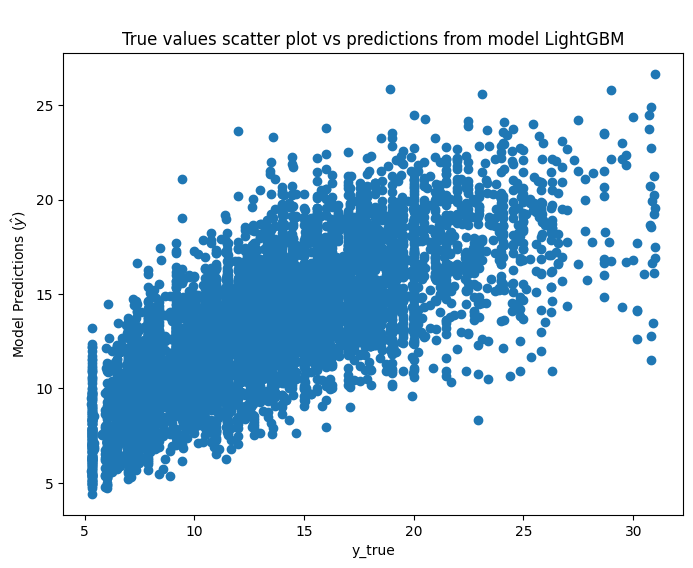

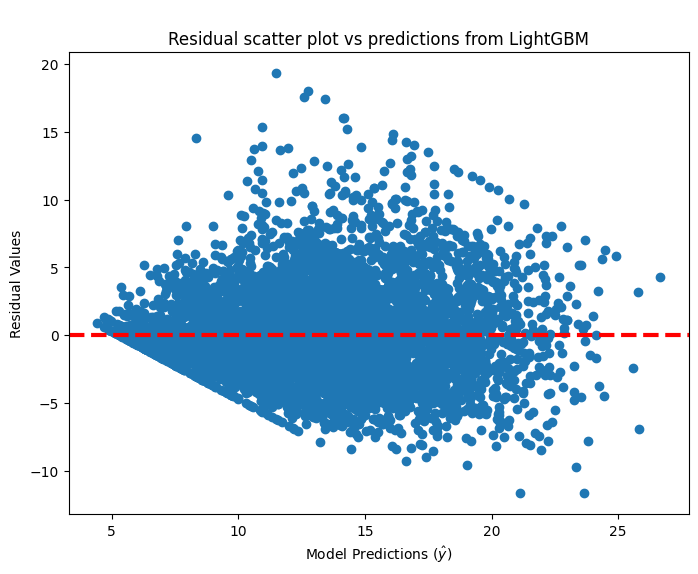

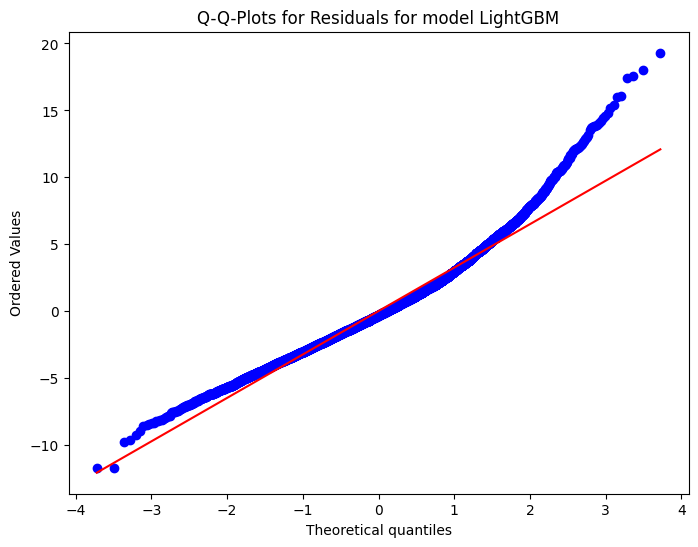

In [61]:
%reload_ext autoreload


residuals = []
y_true = np.reshape(y_test['int_rate'].values, -1)
for model_predicts, name in zip(model_predicts_after, regressors_h):
    y_pred = np.reshape(model_predicts, -1)  # from model_scores
    residual_model = y_true - y_pred

    #print('\n\n\nDiagnostic Plots for Model :' +name+ '\n')
    lfunc.regression_diagnostic_plots(residual_model, y_true, y_pred, name=name)

## Ensemble

### Voting regressor

In [62]:
%%time
%reload_ext autoreload


estimators_list = list(zip(regressors_h,estimators_hyped))

# Need to remove XGBoost because it needs fit_params for early stopping
# - unclear how to implement this without crashing
if 'XGBoost' in regressors_h:
    index = regressors.index(clf_name)
    estimators_list.pop(index)


vot_reg = VotingRegressor(estimators = estimators_list)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('vot_regressors' , vot_reg))

vot_pipe = Pipeline(pipe_steps)

(vot_perf,
 vot_results,
 vot_predict,
 vot_fitted_estimators) = lfunc.model_scores(X_train,y_train,X_test,
                                                     models = [vot_pipe],
                                                     model_type='regression',
                                                     model_names = ['vot_regressors'],
                                                     cv = cvRK)


Executing vot_regressors
Done!
CPU times: user 1min 11s, sys: 14 s, total: 1min 25s
Wall time: 1min 8s


In [63]:
vot_perf.round(3)

,r2 mean,r2 std,explained variance mean,explained variance std,neg median absolute error mean,neg median absolute error std,neg mean absolute error mean,neg mean absolute error std,neg mean squared error mean,neg mean squared error std,neg root mean squared error mean,neg root mean squared error std
vot_regressors,0.502,0.008,0.502,0.008,2.067,0.032,2.55,0.029,11.06,0.248,3.325,0.037





Diagnostic Plots for Model: vot_regressors

Red dashed line: mean residual: 0.04


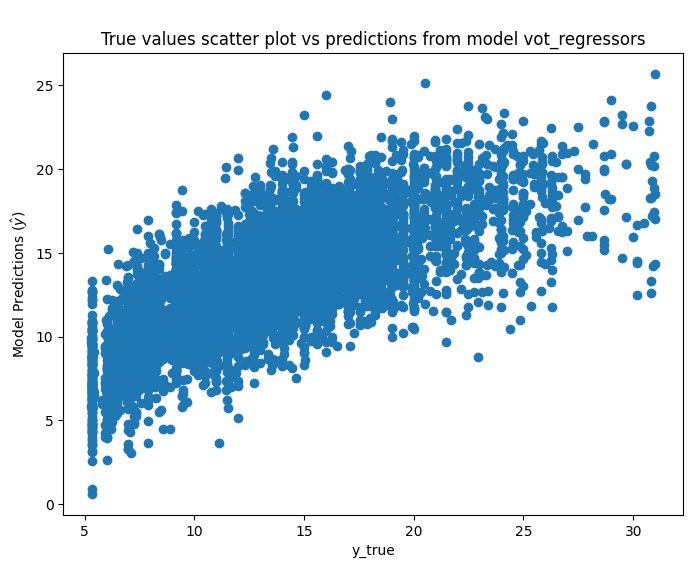

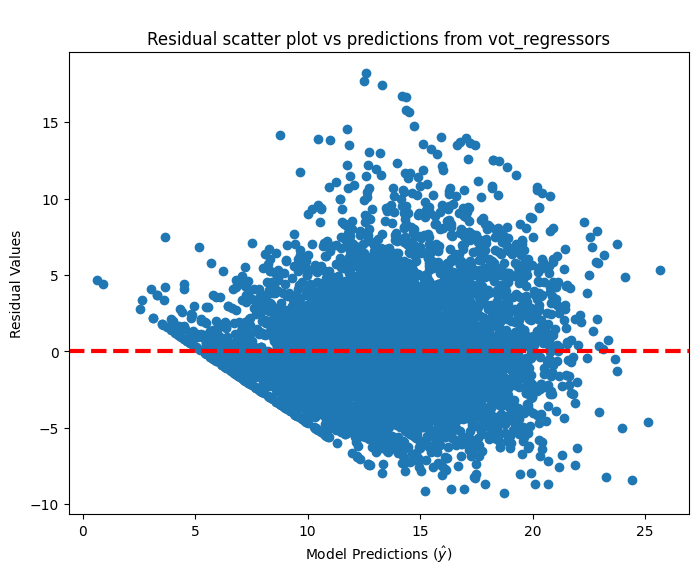

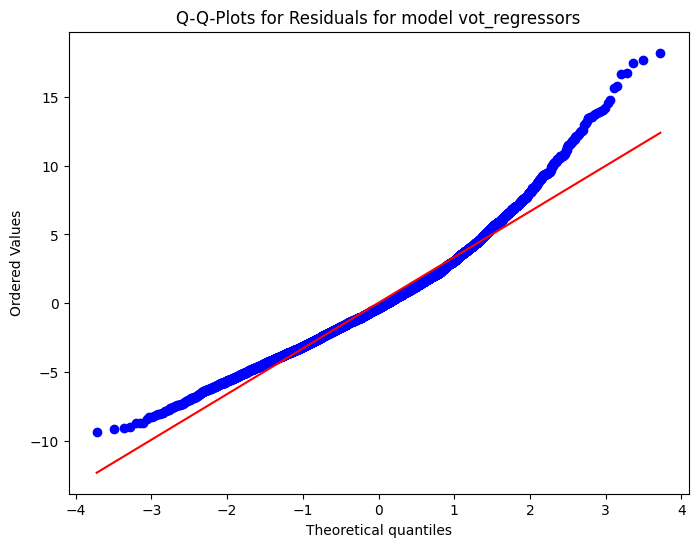

In [64]:
%reload_ext autoreload

predicted = vot_predict
regressors = ['vot_regressors']

y_true = np.reshape(y_test['int_rate'].values, -1)
for model_predicts, name in zip(predicted, regressors):
    y_pred = np.reshape(model_predicts, -1)  # from model_scores
    residual_model = y_true - y_pred
    lfunc.regression_diagnostic_plots(residual_model, y_true, y_pred, name=name)

### Bagging

In [65]:
%%time
%reload_ext autoreload

# XGBoost issues with fit_params again...

regressors_bag = ['Linear Regression', 'Ridge Regression'] #regressors_h #['LightGBM']

bag_names=[]
bag_pipes=[]
for clf_name in regressors_bag:
    clf = regressor_map_h[clf_name]

    #index = regressors_h.index(clf_name)
    #fit_params = fit_params_hyped[index]
    bag_name = 'bag_'+clf_name.replace(' ', '_')
    bag_names.append(bag_name)
    bag_reg = BaggingRegressor(base_estimator=clf,random_state=0,n_estimators=100)

    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append((bag_name , bag_reg))
    bag_pipe = Pipeline(pipe_steps)

    bag_pipes.append(bag_pipe)

(bag_perf,
 bag_results,
 bag_predict,
 bag_fitted_estimators) = lfunc.model_scores(X_train, y_train, X_test,
                                                     models = bag_pipes,
                                                     model_names = bag_names,
                                                     model_type='regression',
                                                     #fit_params = [fit_params],
                                                     cv = cvRK)


Executing bag_Linear_Regression
Executing bag_Ridge_Regression
Done!
CPU times: user 9min 14s, sys: 1min 43s, total: 10min 57s
Wall time: 6min 50s


In [66]:
bag_perf.round(3)

,r2 mean,r2 std,explained variance mean,explained variance std,neg median absolute error mean,neg median absolute error std,neg mean absolute error mean,neg mean absolute error std,neg mean squared error mean,neg mean squared error std,neg root mean squared error mean,neg root mean squared error std
bag_Linear_Regression,0.468,0.009,0.468,0.009,2.164,0.034,2.65,0.029,11.813,0.266,3.437,0.039
bag_Ridge_Regression,0.468,0.009,0.468,0.009,2.165,0.033,2.65,0.029,11.813,0.266,3.437,0.039





Diagnostic Plots for Model: bag_Linear_Regression

Red dashed line: mean residual: 0.05



Diagnostic Plots for Model: bag_Ridge_Regression

Red dashed line: mean residual: 0.05


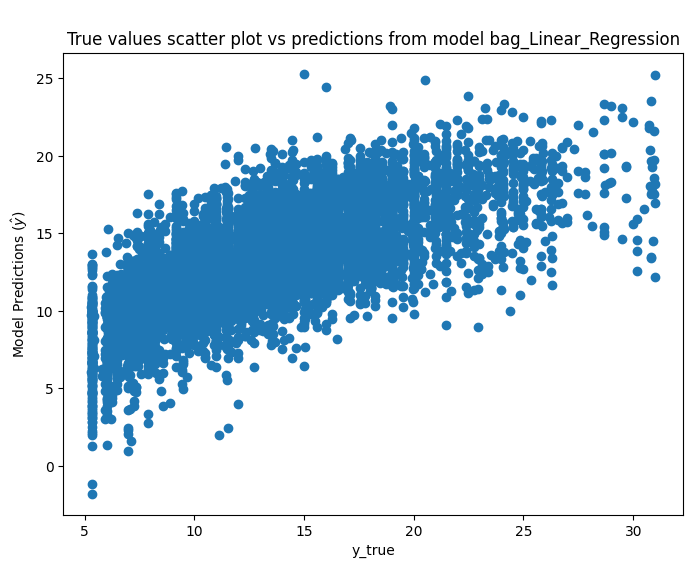

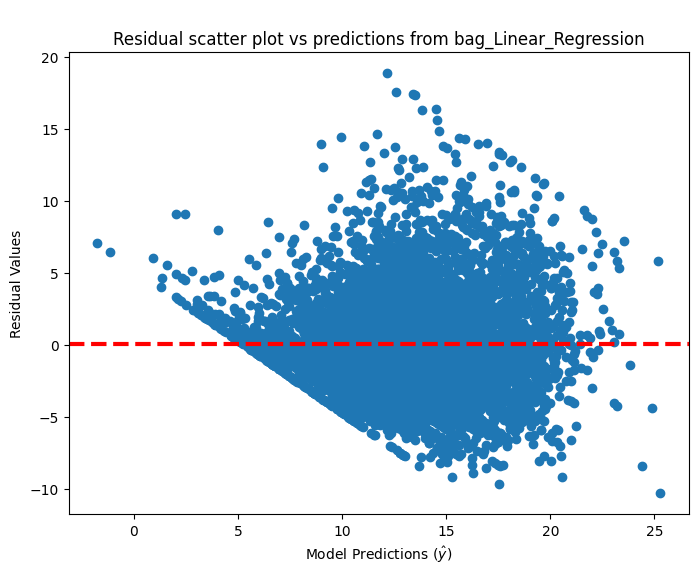

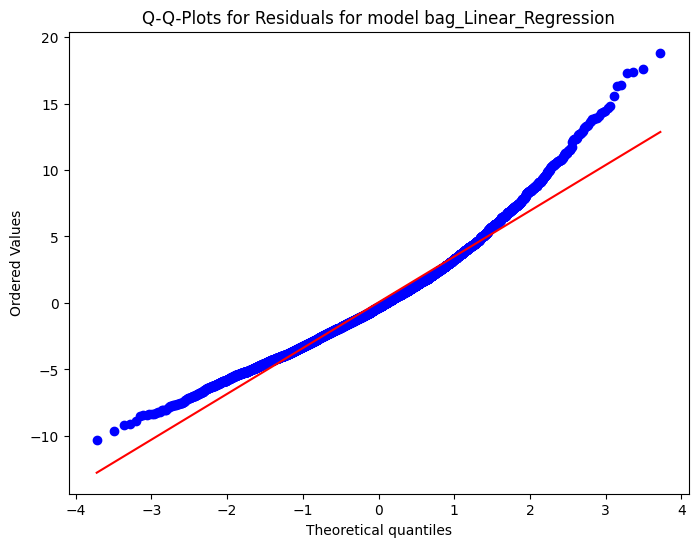

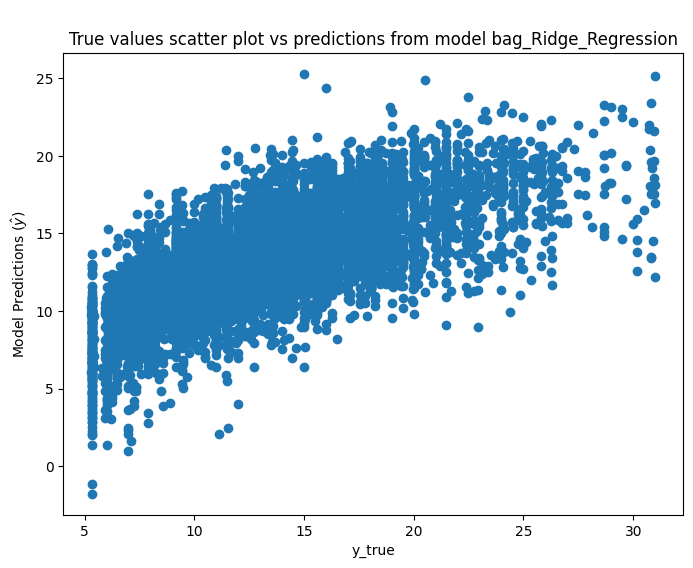

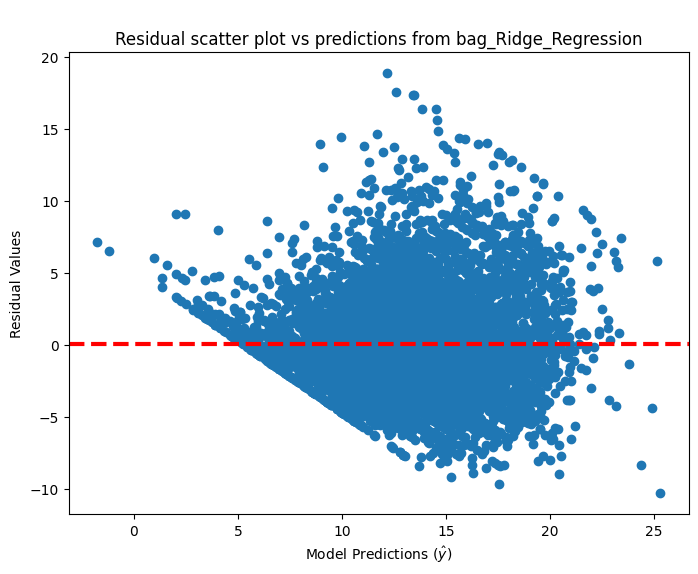

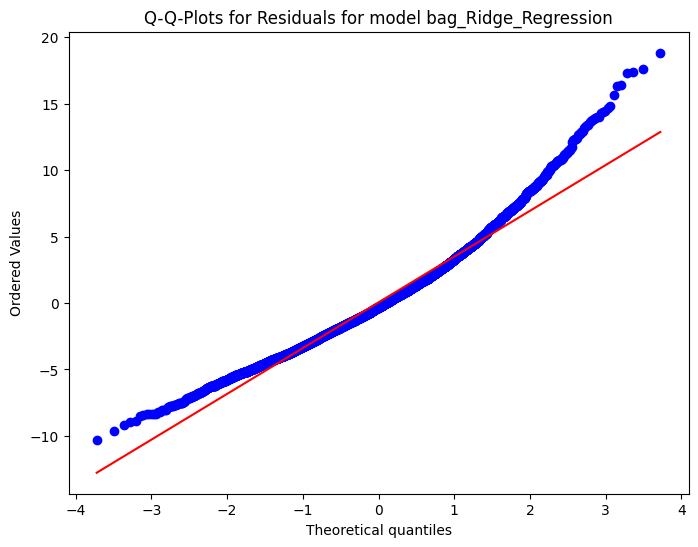

In [67]:
%reload_ext autoreload

predicted = bag_predict
regressors = bag_names

y_true = np.reshape(y_test['int_rate'].values, -1)
for model_predicts, name in zip(predicted, regressors):
    y_pred = np.reshape(model_predicts, -1)  # from model_scores
    residual_model = y_true - y_pred
    lfunc.regression_diagnostic_plots(residual_model, y_true, y_pred, name=name)

## Final Model

Score overview from the previous sections:

In [68]:
print('Hypertuned Models MAE:')
print(model_performance_after['neg mean absolute error mean'])
print('\nVoting Regressors Models MAE:')
print(vot_perf['neg mean absolute error mean'])
print('\nBagged Regressor Models MAE:')
print(bag_perf['neg mean absolute error mean'])

Hypertuned Models MAE:
Linear Regression    2.650466
Ridge Regression     2.650399
LightGBM             2.467141
Name: neg mean absolute error mean, dtype: float64

Voting Regressors Models MAE:
vot_regressors    2.550136
Name: neg mean absolute error mean, dtype: float64

Bagged Regressor Models MAE:
bag_Linear_Regression    2.649806
bag_Ridge_Regression     2.649816
Name: neg mean absolute error mean, dtype: float64


In [69]:
clf_name = 'LightGBM'
index = regressors_h.index(clf_name)
final_model = models_hyped[index]


In [70]:
final_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['inq_last_12m', 'dti',
                                                   'loan_amnt', 'delinq_2yrs',
                                                   'pub_rec_bankruptcies',
                                                   'fico_range_high',
                                                   'annual_inc',
                                                   'mo_sin_old_il_acct']),
                                                 ('num_pca',
                                                  Pipeline(steps=[('imputer',
                                                                   S...
                                            force_row_wise=True,
                                            importance_type='split',
                                            learning_rate=0.13392825388781515,
                                            max_depth=4, min_child_samples=79,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=323, n_jobs=None,
                                            num_leaves=195, objective=None,
                                            random_state=1,
                                            reg_alpha=16.688414670411188,
                                            reg_lambda=1.012824216419752,
                                            subsample=1.0,
                                            subsample_for_bin=200000,
                                            subsample_freq=0,
                                            verbosity=-100))])

In [71]:
filename = home_folder+'int_rate_LightGBM_model.pickle'
pickle.dump(final_model,open(filename, 'wb'))

# Summary

# Improvements

**General**

Feature selection/Cleaning
* less strict on mulitcolinearity
* Less strict on dropping but freq-%
* reduce/bundle classes of features
* Missing values in categoricals: Own class instead of * imputing
* software, e.g. Boruta
* use logarithmic features


Models and Optimization
* try other model, e.g. CatBoost
* failed attempts: TuneSearchCV (internal bugs), * OptunaSearchCV
* Auto-sklearn (grade prediction - not yet finding solutions)

.

**Model-specific**

Linear Regression
* clip outliers

Regression/Classifier Trees
* omit scaling of numericals

Loan acceptance
* Language processing of 'loan_title' → purpose

Grade/Sub-grade
* Classifiers: change class weights manually in estimators
* Linear Regression on ordinal target
* Ordinal Logistic Regression




# Appendix

#### PCA

In [72]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()

transformers=[("num", numeric_transformer, num_feat),
              ]

preprocessor_pca = ColumnTransformer(transformers=transformers,
                                 remainder='passthrough'
                                 )

In [73]:
from sklearn.decomposition import PCA

pca = PCA()
pca_pipe = Pipeline([('preprocessor', preprocessor_pca),
                     ("pca", pca)
                                  ])

In [74]:
X_transformed = pca_pipe.fit_transform(X_train[num_feat])

final = pd.DataFrame(X_transformed[:,:2], columns=['first_component', 'second_component'])

pca_pipe.named_steps['pca'].explained_variance_ratio_


array([1.78714043e-01, 9.20962845e-02, 7.81808647e-02, 6.02782561e-02,
       4.55538558e-02, 3.91261105e-02, 3.42593821e-02, 3.18342484e-02,
       3.08911330e-02, 2.70594471e-02, 2.57782894e-02, 2.32338077e-02,
       2.20490380e-02, 2.09549516e-02, 2.00454288e-02, 1.94925600e-02,
       1.88589461e-02, 1.81565229e-02, 1.68638283e-02, 1.51158645e-02,
       1.37580331e-02, 1.33534620e-02, 1.26055284e-02, 1.16125588e-02,
       1.10300007e-02, 1.04088396e-02, 1.00528202e-02, 9.58594213e-03,
       9.13943583e-03, 9.09764058e-03, 8.11961478e-03, 7.83875754e-03,
       7.51430989e-03, 6.75177347e-03, 6.49385662e-03, 6.31197295e-03,
       5.28599581e-03, 4.95322886e-03, 4.39230017e-03, 2.46889293e-03,
       2.01781929e-03, 1.89732647e-03, 1.77247746e-03, 1.47877245e-03,
       1.17821706e-03, 9.29451074e-04, 7.80355500e-04, 2.80643031e-04,
       2.42240775e-04, 1.04869884e-04])

In [75]:
final = pd.merge(X_train_analysis[best_cat_feat],
                 final, left_index=True, right_index=True)
final.head()

,term,emp_length,home_ownership,verification_status,purpose,first_component,second_component
6,36 months,10+ years,MORTGAGE,Source Verified,debt_consolidation,3.649844,1.803708
11,36 months,< 1 year,RENT,Verified,debt_consolidation,2.029962,-0.811741
11,36 months,10+ years,RENT,Not Verified,credit_card,2.029962,-0.811741
13,60 months,4 years,MORTGAGE,Verified,debt_consolidation,0.013015,-1.683494
15,60 months,2 years,OWN,Source Verified,debt_consolidation,2.977058,-0.761776


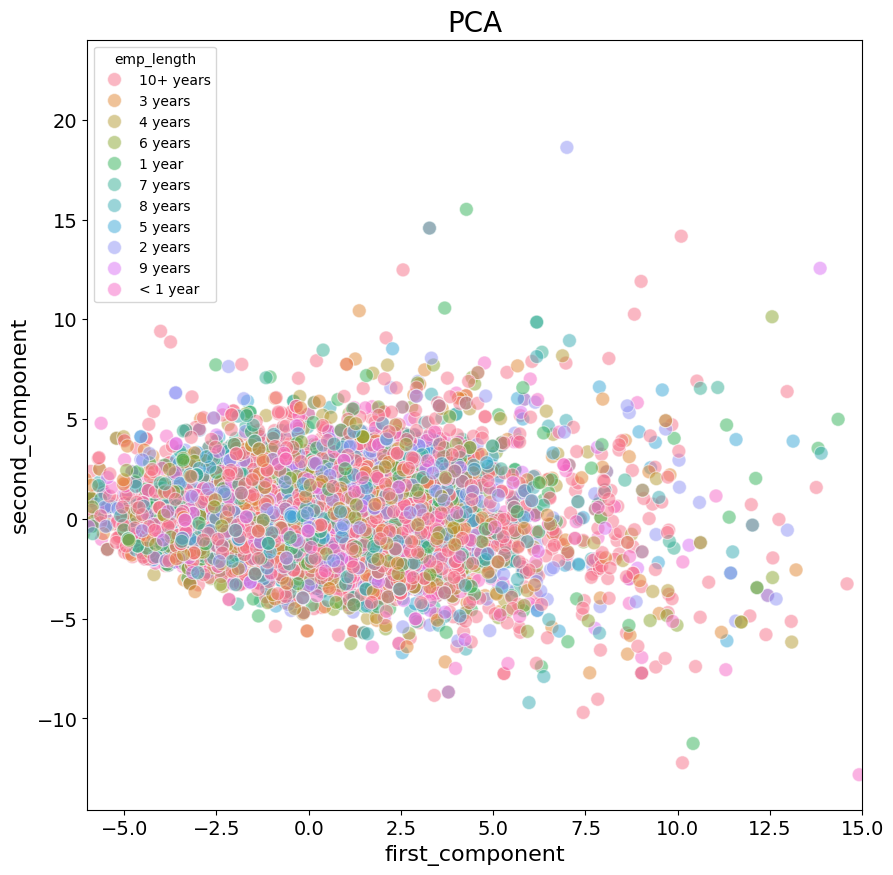

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

hue_list= best_cat_feat
hue = hue_list[7]

fig = sns.scatterplot(final, x='first_component', y='second_component', s=100,
                     alpha=0.5, hue = hue,
                      ax=ax)

ax.set_title('PCA', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-6, 15)
ax.grid(False)


In [ ]:

from matplotlib.patches import Circle
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances


In [ ]:
#Xstd = StandardScaler().fit_transform(X)
#pca = PCA(n_components=2)
Xpca = pca_pipe.fit_transform(X_train)

In [ ]:
len(Xpca)

In [ ]:
eucl_dist = []
for i,j in enumerate(X_train .T):
    corr1 = np.corrcoef(j,Xpca[:,0])[0,1]
    corr2 = np.corrcoef(j,Xpca[:,1])[0,1]
    circle.append((corr1, corr2))
    eucl_dist.append(np.sqrt(corr1**2 + corr2**2))

In [ ]:
with plt.style.context(('seaborn-whitegrid')):
    fig, axs = plt.subplots(figsize=(6, 6))
    for i,j in enumerate(eucl_dist):
        arrow_col = plt.cm.cividis((eucl_dist[i] - np.array(eucl_dist).min())/\
                                (np.array(eucl_dist).max() - np.array(eucl_dist).min()) )
        axs.arrow(0,0, # Arrows start at the origin
                 ccircle[i][0],  #0 for PC1
                 ccircle[i][1],  #1 for PC2
                 lw = 2, # line width
                 length_includes_head=True,
                 color = arrow_col,
                 fc = arrow_col,
                 head_width=0.05,
                 head_length=0.05)
        axs.text(ccircle[i][0]/2,ccircle[i][1]/2, iris.feature_names[i])
    # Draw the unit circle, for clarity
    circle = Circle((0, 0), 1, facecolor='none', edgecolor='k', linewidth=1, alpha=0.5)
    axs.add_patch(circle)
    axs.set_xlabel("PCA 1")
    axs.set_ylabel("PCA 2")
plt.tight_layout()
plt.show()

In [ ]:

X_pca = pca_pipe.fit_transform(X_train)
total_explained_variance = pca_pipe['pca'].explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_pca.shape[1] - n_over_95 + 1
print('Number features: {}\tTotal Variance Explained: {}'.format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))



In [ ]:
X_train_analysis.columns

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

#df = px.data.iris()
features = X_train_analysis.columns.tolist() #['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
#X = df[features]

#pca = PCA(n_components=2)
components = pca_pipe.fit_transform(X_train)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=X_train_analysis['loan_status_simple'])

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


In [ ]:
from yellowbrick.features import PCA

#selected_feat= final_multicol_reduced_feat + cat_feat
#
#X = LCacc_PC_EDA[selected_feat]
#X = X.drop(columns=['grade', 'sub_grade', 'sub_grade', 'loan_status_simple', 'int_rate'])
#y = LCacc_PC_EDA['int_rate'].to_frame()


visualizer = PCA(scale=False, proj_features=True, )
visualizer.fit_transform(X_train_prep)
visualizer.show()